# Lab 1: Guitar tuner

### Petko Petkov

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import get_window
from pathlib import Path
import math
import matplotlib.pyplot as plt

MIN_FREQ = 60.0 # ignore bins below this (hum/DC rejection)
MAINS_NOTCH_UPTO = 62.0 # zero-out spectrum up to this frequency (hum suppression)
MAX_PLOT_FREQ = 1000.0 # x-axis limit for spectrum plot (Hz)

GUITAR_NOTES = {
    "E1": 329.63, # high E
    "B2": 246.94,
    "G3": 196.00,
    "D4": 146.83,
    "A5": 110.00,
    "E6": 82.41, # low E
}
CENT_HZ_PER_STRING = {"E1":0.15,"B2":0.15,"G3":0.15,"D4":0.08,"A5":0.08,"E6":0.04}

In [2]:
def cents_error(measured_hz: float, ref_hz: float) -> float:
    if measured_hz <= 0 or ref_hz <= 0:
        return float('nan')
    return 1200.0 * math.log2(measured_hz / ref_hz)

def quadratic_interpolated_peak(mag: np.ndarray, k: int):
    if k <= 0 or k >= len(mag) - 1:
        return 0.0, mag[k]
    y0 = np.log(mag[k-1] + 1e-12)
    y1 = np.log(mag[k]   + 1e-12)
    y2 = np.log(mag[k+1] + 1e-12)
    denom = 2 * (2*y1 - y0 - y2)
    if denom == 0:
        return 0.0, mag[k]
    delta = (y0 - y2) / denom
    peak_mag = np.exp(y1 - 0.25*(y0 - y2)*delta)
    return float(delta), float(peak_mag)

def estimate_f0_fft(signal: np.ndarray, sr: int) -> float:
    N = len(signal)
    window = get_window("hann", N, fftbins=True)
    xw = signal * window
    nfft = 1 << (N - 1).bit_length()
    spec = np.fft.rfft(xw, n=nfft)
    mag = np.abs(spec)
    freqs = np.fft.rfftfreq(nfft, d=1.0/sr)
    mag[freqs < MAINS_NOTCH_UPTO] = 0.0
    k = int(np.argmax(mag))
    if k <= 0 or k >= len(mag) - 1:
        return 0.0
    delta, _ = quadratic_interpolated_peak(mag, k)
    return float((k + delta) * (sr / nfft))

def read_wav_mono(path: Path):
    sr, data = wavfile.read(str(path))
    if np.issubdtype(data.dtype, np.integer):
        maxv = np.iinfo(data.dtype).max
        data = data.astype(np.float64) / maxv
    else:
        data = data.astype(np.float64)
    if data.ndim == 2:
        data = data.mean(axis=1)
    data = data - np.mean(data)
    return sr, data

def closest_guitar_string(freq_hz: float):
    best = None
    for name, fref in GUITAR_NOTES.items():
        ce = cents_error(freq_hz, fref)
        if math.isnan(ce):
            continue
        if best is None or abs(ce) < abs(best[2]):
            hz_err = freq_hz - fref
            cent_hz_given = CENT_HZ_PER_STRING.get(name)
            best = (name, fref, ce, hz_err, cent_hz_given)
    return best

In [3]:
def plot_spectrum(seg, sr, f0, title_suffix):
    N = len(seg)
    window = get_window("hann", N, fftbins=True)
    xw = seg * window
    nfft = 1 << (N - 1).bit_length()
    spec = np.fft.rfft(xw, n=nfft)
    mag = np.abs(spec)
    freqs = np.fft.rfftfreq(nfft, 1/sr)
    mag[freqs < MAINS_NOTCH_UPTO] = 0.0

    plt.figure()
    plt.title(f"spectrum {title_suffix} (peak - {f0:.2f} Hz)")
    plt.plot(freqs, 20*np.log10(mag + 1e-12))
    plt.xlabel("frequency (Hz)")
    plt.ylabel("magnitude (dB)")
    plt.xlim(0, MAX_PLOT_FREQ)
    plt.grid(True)
    plt.axvline(f0, linestyle="--")
    plt.show()

def plot_spectrogram(seg, sr, title_suffix):
    plt.figure()
    plt.title(f"spectrogram {title_suffix}")
    NFFT = 1024
    noverlap = NFFT // 2
    Pxx, freqs, bins, im = plt.specgram(seg, NFFT=NFFT, Fs=sr, noverlap=noverlap)
    plt.xlabel("time (s)")
    plt.ylabel("frequency (Hz)")
    plt.ylim(0, MAX_PLOT_FREQ)
    plt.show()

In [4]:
def analyze_file(path: Path):
    sr, x = read_wav_mono(path)
    f0 = estimate_f0_fft(x, sr)
    if f0 < MIN_FREQ:
        f0 = estimate_f0_fft(x, sr)

    name, fref, ce, hz_err, cent_hz_given = closest_guitar_string(f0)
    hz_per_cent_theory = fref * (2**(1/1200) - 1)

    result = {
        "file": path.name,
        "samplerate_Hz": sr,
        "detected_f0_Hz": round(f0, 3),
        "closest_string": name,
        "target_freq_Hz": fref,
        "error_cents": round(ce, 2),
        "error_Hz": round(hz_err, 3),
        "theoretical_Hz_per_cent_at_string": round(hz_per_cent_theory, 3),
        "provided_Hz_per_cent_at_string": cent_hz_given,
        "direction": "sharp" if ce > 0 else ("flat" if ce < 0 else "in tune"),
    }

    tag = f"{path.stem}"
    plot_spectrum(x, sr, f0, tag)
    plot_spectrogram(x, sr, tag)

    return result

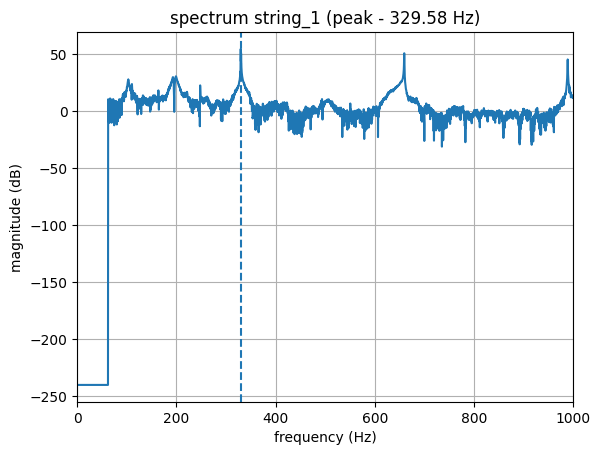

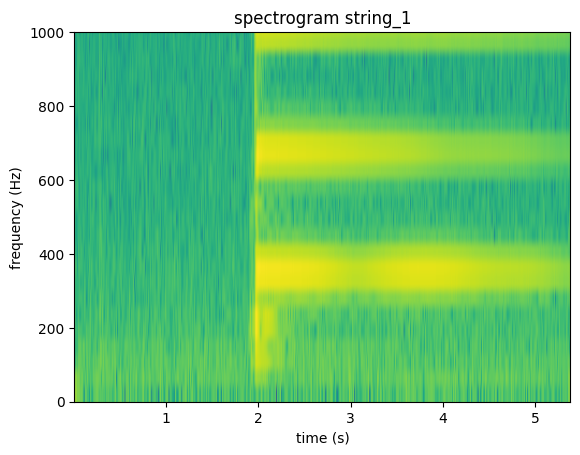

File                           String      f0 (Hz)  Target (Hz) Err (cents)   Err (Hz)     Dir
-----------------------------------------------------------------------------------------------
string_1.wav                   E1          329.576       329.63      -0.28     -0.054    flat


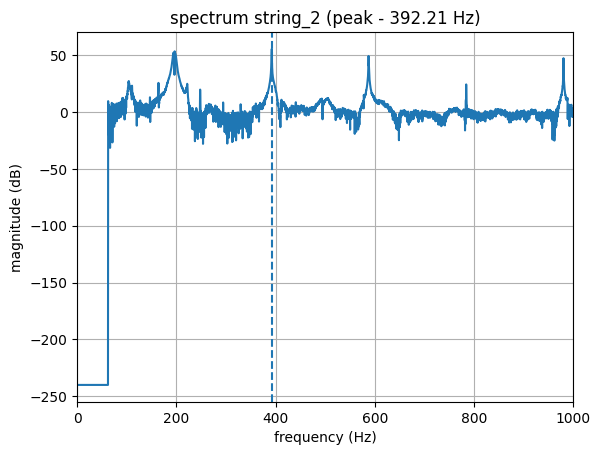

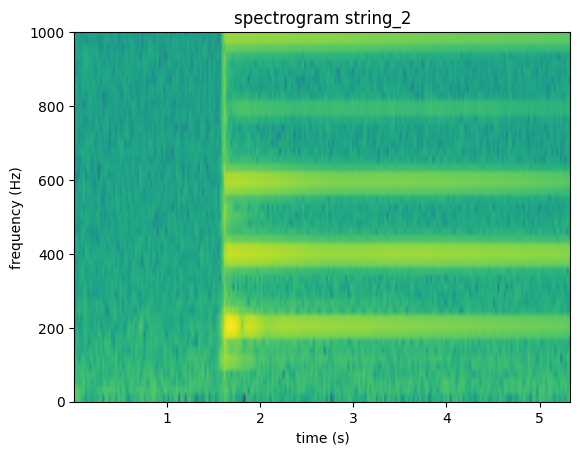

File                           String      f0 (Hz)  Target (Hz) Err (cents)   Err (Hz)     Dir
-----------------------------------------------------------------------------------------------
string_2.wav                   E1          392.209       329.63     300.93     62.579   sharp


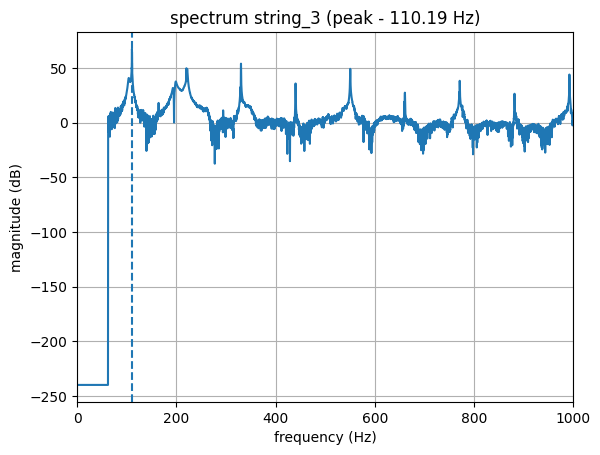

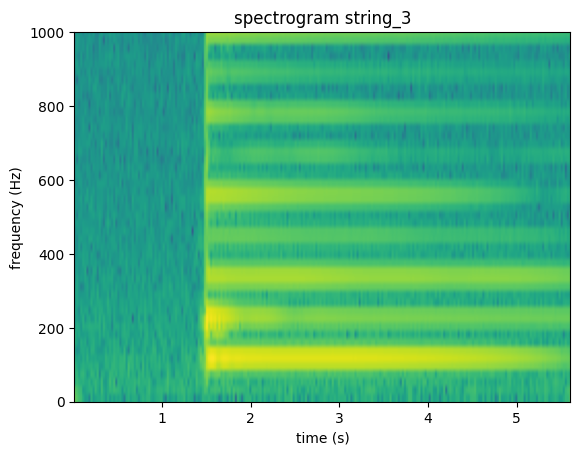

File                           String      f0 (Hz)  Target (Hz) Err (cents)   Err (Hz)     Dir
-----------------------------------------------------------------------------------------------
string_3.wav                   A5          110.188       110.00       2.96      0.188   sharp


In [5]:
def print_results(results):
    print(f"{'File':30} {'String':8} {'f0 (Hz)':>10} {'Target (Hz)':>12} {'Err (cents)':>10} {'Err (Hz)':>10} {'Dir':>7}")
    print("-"*95)
    for r in results:
        print(f"{r['file']:30} {r['closest_string']:8} {r['detected_f0_Hz']:10.3f} "
              f"{r['target_freq_Hz']:12.2f} {r['error_cents']:10.2f} {r['error_Hz']:10.3f} {r['direction']:>7}")

paths = ["../data/string_1.wav", "../data/string_2.wav", "../data/string_3.wav",]
if not paths:
    "no .wav files found"

results = []
for p in paths:
    r = analyze_file(Path(p))
    print_results([r])